In [46]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

sklearn version:  0.24.2
TF version:  2.8.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [47]:
# Load EMNIST dataset
import pandas as pd

train = balanced_train = pd.read_csv("emnist-byclass-train.csv")
test = balanced_test = pd.read_csv("emnist-byclass-test.csv")
mapp = pd.read_csv("emnist-byclass-mapping.txt", 
                   delimiter = ' ', index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

Train: (697931, 785), Test: (116322, 785), Map: (62,)


In [48]:
# Split x and y
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]
del train

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]
del test

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(697931, 784) (697931,) (116322, 784) (116322,)


In [49]:
#preprocesssing
HEIGHT = 28
WIDTH = 28

def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

# Flip and rotate image
X_train = np.asarray(X_train)
X_train = np.apply_along_axis(rotate, 1, X_train)
print ("X_train:",X_train.shape)

X_test = np.asarray(X_test)
X_test = np.apply_along_axis(rotate, 1, X_test)
print ("X_test:",X_test.shape)

X_train: (697931, 28, 28)
X_test: (116322, 28, 28)


In [50]:
# Normalize
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.astype('float32')
X_test /= 255

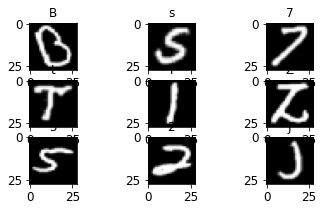

In [51]:
# plot image
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[y_train[i]]))

In [52]:
from keras.utils import np_utils

# number of classes
num_classes = y_train.nunique()

# One hot encoding
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

y_train:  (697931, 62)
y_test:  (116322, 62)


In [53]:
# Reshape image for CNN
X_train = X_train.reshape(-1, HEIGHT, WIDTH, 1)
X_test = X_test.reshape(-1, HEIGHT, WIDTH, 1)

In [54]:
# partition to train and val
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size= 0.20, random_state=7)

In [ ]:
# Define VGG_11 변형(VGG-5) 기본, batchsize=256
tf.random.set_seed(42)
np.random.seed(42)

from functools import partial

DefaultConv2D_G = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model31 = keras.models.Sequential([
    DefaultConv2D_G(filters=32, input_shape=[28, 28, 1]),
    DefaultConv2D_G(filters=32),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=64),
    DefaultConv2D_G(filters=64),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    DefaultConv2D_G(filters=128),
    DefaultConv2D_G(filters=128),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=62, activation='softmax')
])

model31.summary()

In [ ]:
# Compile, train and evaluate
model31.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model31.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_valid, y_valid))

print("\n")
score = model31.evaluate(X_test, y_test)
print('\nTest Accuracy:', score)

In [55]:
# VGG-5 add Batch Nomalization(FC), dropout

tf.random.set_seed(42)
np.random.seed(42)

DefaultConv2D_G = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model4 = keras.models.Sequential([
    DefaultConv2D_G(filters=32, input_shape=[28, 28, 1]),
    DefaultConv2D_G(filters=32),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Dropout(0.25),
    
    DefaultConv2D_G(filters=64),
    DefaultConv2D_G(filters=64),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Dropout(0.25),
    
    DefaultConv2D_G(filters=128),
    DefaultConv2D_G(filters=128),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=62, activation='softmax')
])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

In [56]:
# Compile, train and evaluate
model4.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model4.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_valid, y_valid))

print("\n")
score = model4.evaluate(X_test, y_test)
print('\nTest Accuracy:', score)

Epoch 1/20
2182/2182 [==============================] - 52s 23ms/step - loss: 0.7192 - accuracy: 0.7840 - val_loss: 0.4972 - val_accuracy: 0.8153
Epoch 2/20
2182/2182 [==============================] - 51s 23ms/step - loss: 0.4547 - accuracy: 0.8433 - val_loss: 0.4914 - val_accuracy: 0.8186
Epoch 3/20
2182/2182 [==============================] - 62s 28ms/step - loss: 0.4294 - accuracy: 0.8502 - val_loss: 0.3822 - val_accuracy: 0.8595
Epoch 4/20
2182/2182 [==============================] - 50s 23ms/step - loss: 0.4136 - accuracy: 0.8550 - val_loss: 0.3678 - val_accuracy: 0.8655
Epoch 5/20
2182/2182 [==============================] - 50s 23ms/step - loss: 0.4024 - accuracy: 0.8573 - val_loss: 0.3947 - val_accuracy: 0.8557
Epoch 6/20
2182/2182 [==============================] - 50s 23ms/step - loss: 0.3987 - accuracy: 0.8579 - val_loss: 0.3683 - val_accuracy: 0.8662
Epoch 7/20
2182/2182 [==============================] - 50s 23ms/step - loss: 0.3898 - accuracy: 0.8606 - val_loss: 0.3799 -